In [14]:


# ========================
# SECTION 1: SETUP & IMPORTS
# ========================

# For Colab, uncomment this line:
# !pip install requests pandas numpy matplotlib seaborn torch torchvision scikit-learn plotly

# Check CUDA availability
import torch
print(f" CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f" GPU: {torch.cuda.get_device_name(0)}")
    print(f" CUDA Version: {torch.version.cuda}")
    device = torch.device("cuda")
else:
    print(" Using CPU (CUDA not available)")
    device = torch.device("cpu")

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random









 CUDA Available: False
 Using CPU (CUDA not available)


In [15]:
# ========================
# SECTION 2: EXPERIENCE REPLAY
# ========================

class Experience:
    def __init__(self, state, preference_vector, action, new_state, reward):
        self.state = state
        self.preference_vector = preference_vector
        self.action = action
        self.new_state = new_state
        self.reward = reward

class ExperienceReplayBuffer:
    """Near-on Experience Replay Buffer from MOSEC paper"""
    def __init__(self, capacity=10000, similarity_threshold=0.1):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.similarity_threshold = similarity_threshold

    def add(self, state, preference_vector, action, new_state, reward):
        """Add experience to buffer"""
        experience = Experience(state, preference_vector, action, new_state, reward)
        self.buffer.append(experience)

    def sample(self):
        """Sample random experience from buffer"""
        if len(self.buffer) == 0:
            return None
        return random.choice(self.buffer)

    def size(self):
        return len(self.buffer)

In [16]:
# ========================
# SECTION 3: NER STRATEGY
# ========================

def compute_similarity(cur_state, sampled_state, cur_pref, sampled_pref):
    state_similarity = np.linalg.norm(cur_state - sampled_state, ord=2)
    preference_similarity = np.linalg.norm(cur_pref - sampled_pref, ord=2)
    return state_similarity, preference_similarity

def Sample_NER(sample_coef, batch_size, exp_replay, cur_pref, cur_state):
    if exp_replay.size() == 0:
        return []

    samples_size = min(int(sample_coef * batch_size), exp_replay.size())
    exp_list = []  # (experience, similarity)

    for _ in range(samples_size):
        sample_exp = exp_replay.sample()
        if sample_exp is None:
            continue
        state_sim_score, pref_sim_score = compute_similarity(cur_state, sample_exp.state, cur_pref, sample_exp.preference_vector)
        total_score = state_sim_score + pref_sim_score
        exp_list.append((sample_exp, total_score))

    ordered_exp_list = sorted(exp_list, key=lambda x: x[1])
    return ordered_exp_list[:samples_size]

def generate_random_preference_vector():
    """
    Generates a random preference vector of length 3,
    representing weights for:
    - Profit
    - energy saving
    - compute usage

    The vector components sum to exactly 1.
    """
    # Generate 3 random positive values
    raw_values = [random.random() for _ in range(3)]

    # Normalize so sum is 1
    total = sum(raw_values)
    normalized_vector = np.array([v / total for v in raw_values])
    return normalized_vector

In [17]:
# ========================
# SECTION 4: EF MEMORY
# ========================

class EFMemory:
    """
    EFMemory
    ---------
    • record(ep, vec)  – save a (episode, preference_vector) pair
    • earliest()       – first vector ever stored  (smallest episode)
    • latest()         – most recently stored vector (largest episode)
    """
    def __init__(self):
        self.history = []  # [(episode, vector), …]

    def record(self, episode, vector):
        self.history.append((episode, vector))
        self.history.sort(key=lambda x: x[0])  # keep oldest first

    def earliest(self):
        return self.history[0][1] if self.history else generate_random_preference_vector()

    def latest(self):
        return self.history[-1][1] if self.history else generate_random_preference_vector()

In [18]:
# ========================
# SECTION 5: MULTI-OBJECTIVE DQN
# ========================

class MultiObjectiveDQN(nn.Module):
    """Multi-Objective Deep Q-Network - FIXED VERSION"""
    def __init__(self, state_dim=6, preference_dim=3, action_dim=9, hidden_dim=128):
        super(MultiObjectiveDQN, self).__init__()

        self.state_dim = state_dim
        self.preference_dim = preference_dim
        self.action_dim = action_dim

        # State processing network
        self.state_net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Preference processing network
        self.preference_net = nn.Sequential(
            nn.Linear(preference_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ReLU()
        )

        # Combined processing network
        self.combined_net = nn.Sequential(
            nn.Linear(hidden_dim + hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, state, preference_vector):
        """Forward pass through the network"""
        # Convert to tensors if numpy arrays
        if isinstance(state, np.ndarray):
            state = torch.FloatTensor(state).to(device)
            if len(state.shape) == 1:
                state = state.unsqueeze(0)
        if isinstance(preference_vector, np.ndarray):
            preference_vector = torch.FloatTensor(preference_vector).to(device)
            if len(preference_vector.shape) == 1:
                preference_vector = preference_vector.unsqueeze(0)

        # Process state and preference separately
        state_features = self.state_net(state)
        preference_features = self.preference_net(preference_vector)

        # Combine features
        combined_features = torch.cat([state_features, preference_features], dim=-1)

        # Output Q-values
        q_values = self.combined_net(combined_features)

        return q_values

# ========================
# REAL MARKET DATA INTEGRATION
# ========================

# Your actual market data
REAL_MARKET_DATA = [
    {"energy_price":1.4348419647929662,"hash_price":1.3811512757661435,"token_price":0.8206311309986044,"timestamp":"2025-06-22T00:10:00"},
    {"energy_price":1.418026507707295,"hash_price":1.2506654140798088,"token_price":0.9618932942499107,"timestamp":"2025-06-22T00:05:00"},
    {"energy_price":1.304346972686879,"hash_price":1.4991681367083751,"token_price":1.2772922895215908,"timestamp":"2025-06-22T00:00:00"},
    {"energy_price":1.214559343498124,"hash_price":1.630466851354976,"token_price":1.1254666508453726,"timestamp":"2025-06-21T23:55:00"},
    {"energy_price":1.3221149417438416,"hash_price":1.5179379166699034,"token_price":1.1287863486808096,"timestamp":"2025-06-21T23:50:00"},
    {"energy_price":1.3610987237720158,"hash_price":1.6618913306093814,"token_price":0.9043812692258121,"timestamp":"2025-06-21T23:45:00"},
    {"energy_price":1.336643156689378,"hash_price":2.0984780992282506,"token_price":0.8401810875151633,"timestamp":"2025-06-21T23:40:00"},
    {"energy_price":1.3961249079404732,"hash_price":1.8800761712678364,"token_price":0.7621851691325603,"timestamp":"2025-06-21T23:35:00"},
    {"energy_price":1.277395961869286,"hash_price":1.6647925632563483,"token_price":0.7912260417467961,"timestamp":"2025-06-21T23:30:00"},
    {"energy_price":1.2586537777386257,"hash_price":1.8745076653748538,"token_price":0.7439911129777511,"timestamp":"2025-06-21T23:25:00"},
    {"energy_price":1.1844139373575386,"hash_price":2.312223290085216,"token_price":0.6916147916772093,"timestamp":"2025-06-21T23:20:00"},
    {"energy_price":1.310236258019787,"hash_price":2.3102596948797154,"token_price":0.6574754738522193,"timestamp":"2025-06-21T23:15:00"},
    {"energy_price":1.3428393516832917,"hash_price":2.975865539651656,"token_price":0.6543395534316909,"timestamp":"2025-06-21T23:10:00"},
    {"energy_price":1.3885083748926073,"hash_price":3.058980303980313,"token_price":0.6558745312326324,"timestamp":"2025-06-21T23:05:00"},
    {"energy_price":1.3779365246742996,"hash_price":3.448816953936535,"token_price":0.5673369655067655,"timestamp":"2025-06-21T23:00:00"},
    {"energy_price":1.292651985006823,"hash_price":3.10183236404705,"token_price":0.639494102969435,"timestamp":"2025-06-21T22:55:00"},
    {"energy_price":1.3697812580885278,"hash_price":3.31162847384206,"token_price":0.6549363331424123,"timestamp":"2025-06-21T22:50:00"},
    {"energy_price":1.4203144007665633,"hash_price":3.9675979657652007,"token_price":0.5917432326215619,"timestamp":"2025-06-21T22:45:00"},
    {"energy_price":1.5034799939885293,"hash_price":5.0,"token_price":0.5,"timestamp":"2025-06-21T22:40:00"},
    {"energy_price":1.3691781684382307,"hash_price":4.894475250208856,"token_price":0.5,"timestamp":"2025-06-21T22:35:00"},
    {"energy_price":1.437331128082045,"hash_price":4.522081289244888,"token_price":0.5,"timestamp":"2025-06-21T22:30:00"},
    {"energy_price":1.4552278348307361,"hash_price":4.100294577143592,"token_price":0.5407512530627466,"timestamp":"2025-06-21T22:25:00"},
    {"energy_price":1.6106810153726914,"hash_price":4.14684792051219,"token_price":0.5017044767423046,"timestamp":"2025-06-21T22:20:00"},
    {"energy_price":1.6168372896318741,"hash_price":3.450222468661347,"token_price":0.6467607948213487,"timestamp":"2025-06-21T22:15:00"},
    {"energy_price":1.5152582578359517,"hash_price":2.908722286086614,"token_price":0.5998414041941912,"timestamp":"2025-06-21T22:10:00"},
    {"energy_price":1.505617628469311,"hash_price":3.683254095425921,"token_price":0.5969236922448643,"timestamp":"2025-06-21T22:05:00"},
    {"energy_price":1.6421608607092653,"hash_price":4.379271313256181,"token_price":0.5,"timestamp":"2025-06-21T22:00:00"},
    {"energy_price":1.6472141077525908,"hash_price":4.386625180332106,"token_price":0.590421853818549,"timestamp":"2025-06-21T21:55:00"},
    {"energy_price":1.6998659468197577,"hash_price":3.9407830348019934,"token_price":0.5,"timestamp":"2025-06-21T21:50:00"},
    {"energy_price":1.6540795138330517,"hash_price":3.8749306411302484,"token_price":0.5,"timestamp":"2025-06-21T21:45:00"},
    {"energy_price":1.5890599642476224,"hash_price":4.316202903200794,"token_price":0.5,"timestamp":"2025-06-21T21:40:00"},
    {"energy_price":1.4825706465669317,"hash_price":3.7380941967680683,"token_price":0.5,"timestamp":"2025-06-21T21:35:00"},
    {"energy_price":1.4904690791185,"hash_price":3.7694027234448906,"token_price":0.5737292771383988,"timestamp":"2025-06-21T21:30:00"},
    {"energy_price":1.3585547967638716,"hash_price":3.543978848268665,"token_price":0.5,"timestamp":"2025-06-21T21:25:00"},
    {"energy_price":1.3763879825863758,"hash_price":3.56114990973021,"token_price":0.5,"timestamp":"2025-06-21T21:20:00"},
    {"energy_price":1.3119581047490945,"hash_price":2.8634302388223944,"token_price":0.5626166460293106,"timestamp":"2025-06-21T21:15:00"},
    {"energy_price":1.242943087667474,"hash_price":2.400363475206858,"token_price":0.6248149797814956,"timestamp":"2025-06-21T21:10:00"},
    {"energy_price":1.1321571382075248,"hash_price":2.243796154125973,"token_price":0.7761046053645497,"timestamp":"2025-06-21T21:05:00"},
    {"energy_price":1.1967270125657028,"hash_price":1.8246416892900241,"token_price":0.6544075903029508,"timestamp":"2025-06-21T21:00:00"},
    {"energy_price":1.1986001959215709,"hash_price":2.0482387397487183,"token_price":0.7972573721483327,"timestamp":"2025-06-21T20:55:00"},
    {"energy_price":1.2521184106181291,"hash_price":1.7856593668284617,"token_price":1.0445943070052055,"timestamp":"2025-06-21T20:50:00"},
    {"energy_price":1.2067971149247394,"hash_price":1.5469412061506902,"token_price":1.1819667931411946,"timestamp":"2025-06-21T20:45:00"},
    {"energy_price":1.177758851424358,"hash_price":1.3894203061642358,"token_price":1.4171741711877588,"timestamp":"2025-06-21T20:40:00"},
    {"energy_price":1.2478695181702664,"hash_price":1.2312345384127554,"token_price":1.4828257004804293,"timestamp":"2025-06-21T20:35:00"},
    {"energy_price":1.2695072872530706,"hash_price":1.382032767339416,"token_price":1.5723370784071644,"timestamp":"2025-06-21T20:30:00"},
    {"energy_price":1.2633194804740218,"hash_price":1.411593488168007,"token_price":1.3214849420630612,"timestamp":"2025-06-21T20:25:00"},
    {"energy_price":1.4007314089425429,"hash_price":1.4953222080182915,"token_price":1.5481802559962847,"timestamp":"2025-06-21T20:20:00"},
    {"energy_price":1.471089062999324,"hash_price":1.245712977648062,"token_price":1.6422635427784182,"timestamp":"2025-06-21T20:15:00"},
    {"energy_price":1.3524796343619556,"hash_price":1.0965644012635416,"token_price":1.3409703208833021,"timestamp":"2025-06-21T20:10:00"},
    {"energy_price":1.4702898967985976,"hash_price":1.4176989813689835,"token_price":1.1889606447692915,"timestamp":"2025-06-21T20:05:00"},
    {"energy_price":1.373449899896457,"hash_price":1.3068414581120602,"token_price":1.0241993653789758,"timestamp":"2025-06-21T20:00:00"},
    {"energy_price":1.3158261890187521,"hash_price":1.6862215149640938,"token_price":1.1061386676196705,"timestamp":"2025-06-21T19:55:00"},
    {"energy_price":1.4124149430780548,"hash_price":1.6452360741024257,"token_price":1.0051279914607045,"timestamp":"2025-06-21T19:50:00"},
    {"energy_price":1.4611966107117,"hash_price":1.582948114277705,"token_price":0.8294100870227179,"timestamp":"2025-06-21T19:45:00"},
    {"energy_price":1.5881855620928116,"hash_price":1.4970006834589273,"token_price":0.9095486348264297,"timestamp":"2025-06-21T19:40:00"},
    {"energy_price":1.7123601678644838,"hash_price":1.5143912804114072,"token_price":0.8529207088500484,"timestamp":"2025-06-21T19:35:00"},
    {"energy_price":1.7080768161076856,"hash_price":1.897032096449882,"token_price":0.862233251473669,"timestamp":"2025-06-21T19:30:00"},
    {"energy_price":1.845335399385394,"hash_price":2.1626418829667946,"token_price":1.1376922008659587,"timestamp":"2025-06-21T19:25:00"},
    {"energy_price":2.0429798360618627,"hash_price":2.3299399333355315,"token_price":1.2812970820291874,"timestamp":"2025-06-21T19:20:00"},
    {"energy_price":2.0154193360600683,"hash_price":1.8768285643244564,"token_price":1.3792307700955946,"timestamp":"2025-06-21T19:15:00"},
    {"energy_price":2.124722828696537,"hash_price":1.5738691781774317,"token_price":1.1190401841114341,"timestamp":"2025-06-21T19:10:00"},
    {"energy_price":2.0176690042684924,"hash_price":1.8728910650534818,"token_price":1.1234012097440238,"timestamp":"2025-06-21T19:05:00"},
    {"energy_price":1.8928593307908825,"hash_price":2.069299113308325,"token_price":0.9353659827206785,"timestamp":"2025-06-21T19:00:00"},
    {"energy_price":2.0406929224133683,"hash_price":2.1759449523618533,"token_price":0.8418130761269937,"timestamp":"2025-06-21T18:55:00"},
    {"energy_price":2.2029704229031415,"hash_price":1.8226466994869919,"token_price":0.8684675325366232,"timestamp":"2025-06-21T18:50:00"},
    {"energy_price":2.045145609505393,"hash_price":2.40326505959667,"token_price":0.8561544190388235,"timestamp":"2025-06-21T18:45:00"},
    {"energy_price":1.9229422461523735,"hash_price":2.559602352401579,"token_price":1.0303313599090151,"timestamp":"2025-06-21T18:40:00"},
    {"energy_price":1.8702161706778901,"hash_price":2.273421323432612,"token_price":1.1408575129252492,"timestamp":"2025-06-21T18:35:00"},
    {"energy_price":1.806929919349425,"hash_price":2.574225145138116,"token_price":1.0702114138832242,"timestamp":"2025-06-21T18:30:00"},
    {"energy_price":1.929364877941417,"hash_price":2.2659161470862017,"token_price":1.3876125693773425,"timestamp":"2025-06-21T18:25:00"},
    {"energy_price":1.9434705881658805,"hash_price":1.9452869935785269,"token_price":1.2791261211926324,"timestamp":"2025-06-21T18:20:00"},
    {"energy_price":2.079819580303831,"hash_price":1.6092416701427907,"token_price":1.0595463081150989,"timestamp":"2025-06-21T18:15:00"},
    {"energy_price":1.9144749886704997,"hash_price":1.5398565848132326,"token_price":1.0436381597355893,"timestamp":"2025-06-21T18:10:00"},
    {"energy_price":1.984027238583312,"hash_price":1.6698249317529188,"token_price":1.2715536662463782,"timestamp":"2025-06-21T18:05:00"},
    {"energy_price":1.8451797164716208,"hash_price":1.427392128310683,"token_price":1.2294913381730583,"timestamp":"2025-06-21T18:00:00"},
    {"energy_price":1.7389817055224288,"hash_price":1.2887871606724588,"token_price":1.0531011396298866,"timestamp":"2025-06-21T17:55:00"},
    {"energy_price":1.8601105590904605,"hash_price":1.2876881465587846,"token_price":1.055133872429775,"timestamp":"2025-06-21T17:50:00"},
    {"energy_price":1.746094340270338,"hash_price":1.3179563481367562,"token_price":1.140850555312972,"timestamp":"2025-06-21T17:45:00"},
    {"energy_price":1.9063667910336508,"hash_price":1.1863662668321335,"token_price":1.3036651598565343,"timestamp":"2025-06-21T17:40:00"},
    {"energy_price":1.8224772635774706,"hash_price":1.3695909257825103,"token_price":1.262747256826016,"timestamp":"2025-06-21T17:35:00"},
    {"energy_price":1.7998173872419583,"hash_price":1.6657866779202368,"token_price":1.4143655710724112,"timestamp":"2025-06-21T17:30:00"},
    {"energy_price":1.6525039605641958,"hash_price":1.7056166536914859,"token_price":1.8333139909820786,"timestamp":"2025-06-21T17:25:00"},
    {"energy_price":1.6016339212907367,"hash_price":1.7500019800415323,"token_price":1.554540075329758,"timestamp":"2025-06-21T17:20:00"},
    {"energy_price":1.696935088607072,"hash_price":1.6684374862462754,"token_price":1.2652189497959736,"timestamp":"2025-06-21T17:15:00"},
    {"energy_price":1.6114572696419474,"hash_price":1.5974585343561345,"token_price":1.6600020521956633,"timestamp":"2025-06-21T17:10:00"},
    {"energy_price":1.6499129234976313,"hash_price":1.6313191464959127,"token_price":1.884948630978098,"timestamp":"2025-06-21T17:05:00"},
    {"energy_price":1.6838263118826167,"hash_price":1.4236064848713739,"token_price":2.298448011395055,"timestamp":"2025-06-21T17:00:00"},
    {"energy_price":1.6183695111093013,"hash_price":1.504546973016291,"token_price":2.2196318765890273,"timestamp":"2025-06-21T16:55:00"},
    {"energy_price":1.7111753078494565,"hash_price":1.6320802464848037,"token_price":2.2813915269682123,"timestamp":"2025-06-21T16:50:00"},
    {"energy_price":1.7438290771285645,"hash_price":1.776148504603014,"token_price":2.0488152005050213,"timestamp":"2025-06-21T16:45:00"},
    {"energy_price":1.6488996360954884,"hash_price":1.4561949520036743,"token_price":1.8670924463100143,"timestamp":"2025-06-21T16:40:00"},
    {"energy_price":1.804246668156833,"hash_price":1.4267784643417052,"token_price":2.0107813414394764,"timestamp":"2025-06-21T16:35:00"},
    {"energy_price":1.8303835668438346,"hash_price":1.6998405065486835,"token_price":2.087255155842207,"timestamp":"2025-06-21T16:30:00"},
    {"energy_price":1.7532294616184587,"hash_price":1.371063996625901,"token_price":1.9913316886215637,"timestamp":"2025-06-21T16:25:00"},
    {"energy_price":1.808362712546183,"hash_price":1.1391693102512688,"token_price":2.2464288283232516,"timestamp":"2025-06-21T16:20:00"},
    {"energy_price":1.8643838903946917,"hash_price":1.0,"token_price":2.704000403383978,"timestamp":"2025-06-21T16:15:00"},
    {"energy_price":1.7609874535384165,"hash_price":1.0,"token_price":2.6195580742282583,"timestamp":"2025-06-21T16:10:00"},
    {"energy_price":1.629939806164297,"hash_price":1.133165121971191,"token_price":3.029793718798569,"timestamp":"2025-06-21T16:05:00"},
    {"energy_price":1.7515483259716864,"hash_price":1.0,"token_price":2.793642474075807,"timestamp":"2025-06-21T16:00:00"},
    {"energy_price":1.7948876293821259,"hash_price":1.0,"token_price":2.3042994284488563,"timestamp":"2025-06-21T15:55:00"},
    {"energy_price":1.6383081775782342,"hash_price":1.241199940800506,"token_price":1.9223334996047612,"timestamp":"2025-06-21T15:50:00"},
    {"energy_price":1.5795116078836193,"hash_price":1.0555708013478051,"token_price":1.8584753555746947,"timestamp":"2025-06-21T15:45:00"},
    {"energy_price":1.4515927649972435,"hash_price":1.3367520713558894,"token_price":1.6953528059088714,"timestamp":"2025-06-21T15:40:00"},
    {"energy_price":1.3820239426072973,"hash_price":1.463847149891246,"token_price":1.6093340967472618,"timestamp":"2025-06-21T15:35:00"},
    {"energy_price":1.3034804993549014,"hash_price":1.3595593677377351,"token_price":2.0147764149625593,"timestamp":"2025-06-21T15:30:00"},
    {"energy_price":1.3188496098853923,"hash_price":1.233065430855294,"token_price":1.8815331654256284,"timestamp":"2025-06-21T15:25:00"},
    {"energy_price":1.2297292121797345,"hash_price":1.412985218745328,"token_price":1.9179808075569176,"timestamp":"2025-06-21T15:20:00"},
    {"energy_price":1.3653943387723644,"hash_price":1.2432342060213746,"token_price":2.282977958440174,"timestamp":"2025-06-21T15:15:00"},
    {"energy_price":1.275232355404469,"hash_price":1.0453144753440822,"token_price":2.1430228525467534,"timestamp":"2025-06-21T15:10:00"},
    {"energy_price":1.2402367408640083,"hash_price":1.0107218117012238,"token_price":2.272409561223678,"timestamp":"2025-06-21T15:05:00"},
    {"energy_price":1.2570967132727928,"hash_price":1.1192622602014088,"token_price":2.0370388964312163,"timestamp":"2025-06-21T15:00:00"},
    {"energy_price":1.3198184209829842,"hash_price":1.0,"token_price":1.8702080180436216,"timestamp":"2025-06-21T14:55:00"},
    {"energy_price":1.2193061835588612,"hash_price":1.0726747403240042,"token_price":1.7775839628423784,"timestamp":"2025-06-21T14:50:00"},
    {"energy_price":1.1618430006547407,"hash_price":1.2800969121756303,"token_price":2.067595884287765,"timestamp":"2025-06-21T14:45:00"},
    {"energy_price":1.1975716475481823,"hash_price":1.0827607415479756,"token_price":1.9018819519631294,"timestamp":"2025-06-21T14:40:00"},
    {"energy_price":1.2367439674788283,"hash_price":1.0,"token_price":2.2282832603275016,"timestamp":"2025-06-21T14:35:00"},
    {"energy_price":1.3492947007931393,"hash_price":1.0859370203021304,"token_price":2.922311254551511,"timestamp":"2025-06-21T14:30:00"},
    {"energy_price":1.4447801969040053,"hash_price":1.0776126163970894,"token_price":2.6510988366539703,"timestamp":"2025-06-21T14:25:00"},
    {"energy_price":1.4120116463317736,"hash_price":1.1658419393068609,"token_price":3.004868568816915,"timestamp":"2025-06-21T14:20:00"},
    {"energy_price":1.5500352223818865,"hash_price":1.3885491699352182,"token_price":2.6264369748022176,"timestamp":"2025-06-21T14:15:00"},
    {"energy_price":1.5199170324386495,"hash_price":1.5428238375214949,"token_price":2.733815453183654,"timestamp":"2025-06-21T14:10:00"},
    {"energy_price":1.4762145354089435,"hash_price":1.3420952980510317,"token_price":2.2578966593443788,"timestamp":"2025-06-21T14:05:00"},
    {"energy_price":1.444815951120728,"hash_price":1.4201148456261992,"token_price":2.2712838460960687,"timestamp":"2025-06-21T14:00:00"},
    {"energy_price":1.596021142208885,"hash_price":1.2500497551742207,"token_price":2.5021535587871018,"timestamp":"2025-06-21T13:55:00"},
    {"energy_price":1.6898657472700116,"hash_price":1.2270042839737085,"token_price":2.003885827694914,"timestamp":"2025-06-21T13:50:00"},
    {"energy_price":1.7929799028621094,"hash_price":1.0,"token_price":1.6619440711350901,"timestamp":"2025-06-21T13:45:00"},
    {"energy_price":1.97602518771756,"hash_price":1.040334939895301,"token_price":1.4201888897158326,"timestamp":"2025-06-21T13:40:00"},
    {"energy_price":2.1833031973734753,"hash_price":1.1529874940740352,"token_price":1.1374595810988168,"timestamp":"2025-06-21T13:35:00"},
    {"energy_price":2.052262070285911,"hash_price":1.4448100625927258,"token_price":1.4291363334541027,"timestamp":"2025-06-21T13:30:00"},
    {"energy_price":2.2684126113670517,"hash_price":1.8835879832275757,"token_price":1.8102186951829016,"timestamp":"2025-06-21T13:25:00"},
    {"energy_price":2.3412353474152137,"hash_price":1.8235324527686736,"token_price":1.6837631625847003,"timestamp":"2025-06-21T13:20:00"},
    {"energy_price":2.305221706702797,"hash_price":1.7768358940711155,"token_price":1.385501899558786,"timestamp":"2025-06-21T13:15:00"},
    {"energy_price":2.2853200855034403,"hash_price":1.4976465187047878,"token_price":1.743502918728721,"timestamp":"2025-06-21T13:10:00"},
    {"energy_price":2.3498939771301406,"hash_price":1.3504167805668617,"token_price":2.0273055016681845,"timestamp":"2025-06-21T13:05:00"},
    {"energy_price":2.297717973427244,"hash_price":1.5803107788757957,"token_price":2.3548126115417296,"timestamp":"2025-06-21T13:00:00"},
    {"energy_price":2.3818854331354027,"hash_price":1.6191816880397647,"token_price":2.2571653560682776,"timestamp":"2025-06-21T12:55:00"},
    {"energy_price":2.365256246613027,"hash_price":1.7098943201033563,"token_price":2.798995902339271,"timestamp":"2025-06-21T12:50:00"},
    {"energy_price":2.1536024355362566,"hash_price":1.7413421461671155,"token_price":2.4916953289704087,"timestamp":"2025-06-21T12:45:00"},
    {"energy_price":2.058179001721047,"hash_price":1.634949480135776,"token_price":2.330908588656266,"timestamp":"2025-06-21T12:40:00"},
    {"energy_price":2.0468088342804367,"hash_price":1.4129289741763094,"token_price":1.898587919029327,"timestamp":"2025-06-21T12:35:00"},
    {"energy_price":2.0666908811445475,"hash_price":1.7494842433104154,"token_price":2.278233858712874,"timestamp":"2025-06-21T12:30:00"},
    {"energy_price":2.2876857514893723,"hash_price":2.2995969782373704,"token_price":2.3968270249295793,"timestamp":"2025-06-21T12:25:00"},
    {"energy_price":2.390756777708582,"hash_price":2.1201602463639584,"token_price":2.2901146387886997,"timestamp":"2025-06-21T12:20:00"},
    {"energy_price":2.597212224340673,"hash_price":2.6727284034211714,"token_price":2.260936090847102,"timestamp":"2025-06-21T12:15:00"},
    {"energy_price":2.757013928096431,"hash_price":3.071304532698384,"token_price":2.280856393566899,"timestamp":"2025-06-21T12:10:00"},
    {"energy_price":2.860623306283185,"hash_price":3.162577507313854,"token_price":2.3421444297660767,"timestamp":"2025-06-21T12:05:00"},
    {"energy_price":3.0,"hash_price":4.0,"token_price":2.0,"timestamp":"2025-06-21T12:00:00"}
]

# Real price statistics
REAL_PRICE_STATS = {
    "energy": {"min": 1.0, "max": 3.0, "mean": 1.6},
    "hash": {"min": 1.0, "max": 5.0, "mean": 2.1},
    "token": {"min": 0.5, "max": 3.0, "mean": 1.4}
}

# Updated inventory with air2 miners
INVENTORY = {
    "inference": {
        "asic": {
            "power": 15000,
            "tokens": 50000
        },
        "gpu": {
            "power": 5000,
            "tokens": 1000
        }
    },
    "miners": {
        "air": {
            "hashrate": 1000,
            "power": 3500
        },
        "air2": {
            "hashrate": 1000,
            "power": 3500
        },
        "hydro": {
            "hashrate": 5000,
            "power": 5000
        },
        "immersion": {
            "hashrate": 10000,
            "power": 10000
        }
    }
}

# Sample state from the research/API
sample_state = {
    "energy_price": 1.38850837489261,
    "hash_price": 3.05898030398031,
    "token_price": 0.655874531232632
}

# Sample site configuration representing /machines endpoint
sample_site = {
    "site_id": 0,
    "id": 988,
    "air_miners": 0,
    "hydro_miners": 0,
    "immersion_miners": 5,
    "gpu_compute": 10,
    "asic_compute": 5,
    "updated_at": "2025-06-21T23:36:07.432517",
    "total_power_used": 133330,
    "total_power_cost": 186145.33397570328,
    "total_revenue": 73678.38520133552,
    "power": {
        "air_miners": 0,
        "hydro_miners": 0,
        "immersion_miners": 50000,
        "gpu_compute": 33330,
        "asic_compute": 50000
    },
    "revenue": {
        "air_miners": 0.0,
        "hydro_miners": 0.0,
        "immersion_miners": 47001.90428169591,
        "gpu_compute": 7621.851691325603,
        "asic_compute": 19054.629228314006
    }
}

# Updated action space: (inference_ratio, mining_ratio) pairs
# These represent percentage allocation of total power
ACTION_SPACE_RATIOS = [
    (0.0, 1.0),   # 0% inference, 100% mining
    (0.1, 0.9),   # 10% inference, 90% mining
    (0.2, 0.8),   # 20% inference, 80% mining
    (0.3, 0.7),   # 30% inference, 70% mining
    (0.4, 0.6),   # 40% inference, 60% mining
    (0.5, 0.5),   # 50% inference, 50% mining
    (0.6, 0.4),   # 60% inference, 40% mining
    (0.7, 0.3),   # 70% inference, 30% mining
    (0.8, 0.2),   # 80% inference, 20% mining
    (0.9, 0.1),   # 90% inference, 10% mining
    (1.0, 0.0),   # 100% inference, 0% mining
]

In [19]:
# ========================
# SECTION 7: ENHANCED ENVIRONMENT - FIXED RESEARCH VERSION
# ========================

class Environment:
    """Enhanced Environment based on research implementation"""

    P_TOTAL = 1_000_000  # total available watts (1MW)

    def __init__(self):
        self.inventory = INVENTORY
        self.site = sample_site.copy()  # Available machines on site
        self.time_step = 0

    def get_real_market_prices(self):
        """Use fake market data instead of simulation"""
        # Cycle through fake market data
        data_index = (self.time_step) % len(REAL_MARKET_DATA)
        current_data = REAL_MARKET_DATA[data_index]

        # Add small random variations to make training more robust
        energy_noise = np.random.normal(0, 0.05)  # ±5% variation
        hash_noise = np.random.normal(0, 0.05)
        token_noise = np.random.normal(0, 0.05)

        return {
            "energy_price": max(0.5, current_data["energy_price"] + energy_noise),
            "hash_price": max(1.0, current_data["hash_price"] + hash_noise),
            "token_price": max(0.5, current_data["token_price"] + token_noise),
            "timestamp": current_data["timestamp"]
        }

    def get_simulated_prices(self):
        """DEPRECATED: Use get_real_market_prices() instead"""
        return self.get_real_market_prices()

    def get_current_state(self):
        """Get current state representation"""
        prices = self.get_simulated_prices()

        # State: [energy_price, hash_price, token_price, power_usage_ratio, mining_efficiency, token_efficiency]
        current_power_usage = self.site.get("total_power_used", 0)
        power_ratio = current_power_usage / self.P_TOTAL

        # Calculate efficiency metrics
        mining_efficiency = self.site.get("revenue", {}).get("immersion_miners", 0) / max(1, self.site.get("power", {}).get("immersion_miners", 1))
        token_efficiency = self.site.get("revenue", {}).get("asic_compute", 0) / max(1, self.site.get("power", {}).get("asic_compute", 1))

        state = np.array([
            prices["energy_price"],
            prices["hash_price"],
            prices["token_price"],
            power_ratio,
            mining_efficiency / 1000,  # Normalize
            token_efficiency / 1000    # Normalize
        ])

        return state

    def step(self, action, pref_vector):
        """Execute action using greedy allocation strategy from research"""
        self.time_step += 1

        # Get action ratios
        if action >= len(ACTION_SPACE_RATIOS):
            action = 0
        infer_ratio, mining_ratio = ACTION_SPACE_RATIOS[action]

        # Get current prices
        prices = self.get_simulated_prices()

        # Calculate power allocations
        P_infer_rem = infer_ratio * self.P_TOTAL
        P_mine_rem = mining_ratio * self.P_TOTAL

        # Check if allocation exceeds total power constraint
        if (P_infer_rem + P_mine_rem) > self.P_TOTAL:
            # Invalid action - penalize heavily
            reward = -10000
            return self.get_current_state(), reward

        # ==========================================
        # GREEDY INFERENCE ALLOCATION (from research)
        # ==========================================

        # Sort inference machines by tokens-per-watt descending
        inf_order = sorted(
            self.inventory['inference'].items(),
            key=lambda kv: kv[1]['tokens'] / kv[1]['power'],
            reverse=True
        )

        power_inf_used = 0
        tokens_generated = 0

        for inf_name, specs in inf_order:
            unit_p = specs['power']
            unit_t = specs['tokens']
            # How many you actually have on-site
            available = self.site.get(f"{inf_name}_compute", 0)
            # How many you *could* power
            max_by_power = int(P_infer_rem // unit_p) if unit_p > 0 else 0
            n = min(available, max_by_power)
            if n <= 0:
                continue
            # Consume power & produce tokens
            used = n * unit_p
            power_inf_used += used
            tokens_generated += n * unit_t
            P_infer_rem -= used
            # Stop if no more inference power budget
            if P_infer_rem < min([m['power'] for m in self.inventory['inference'].values()]):
                break

        # ==========================================
        # GREEDY MINING ALLOCATION (from research)
        # ==========================================

        # Sort miners by (hashrate-per-watt, hashrate) descending
        mine_order = sorted(
            self.inventory['miners'].items(),
            key=lambda kv: (kv[1]['hashrate'] / kv[1]['power'], kv[1]['hashrate']),
            reverse=True
        )

        power_mine_used = 0
        hash_generated = 0

        for mine_name, specs in mine_order:
            unit_p = specs['power']
            unit_h = specs['hashrate']
            available = self.site.get(f"{mine_name}_miners", 0)
            max_by_power = int(P_mine_rem // unit_p) if unit_p > 0 else 0
            n = min(available, max_by_power)
            if n <= 0:
                continue
            used = n * unit_p
            power_mine_used += used
            hash_generated += n * unit_h
            P_mine_rem -= used
            if P_mine_rem < min([m['power'] for m in self.inventory['miners'].values()]):
                break

        # ==========================================
        # PRICING & REVENUE CALCULATION (from research)
        # ==========================================

        ep = prices['energy_price']
        hp = prices['hash_price']
        tp = prices['token_price']

        mining_revenue = hash_generated * hp
        infer_revenue = tokens_generated * tp
        total_revenue = mining_revenue + infer_revenue

        # COSTS
        total_cost = self.P_TOTAL * ep  # Pay for full power capacity

        # METRICS
        profit = total_revenue - total_cost
        energy_usage = power_inf_used + power_mine_used
        compute_idle = self.P_TOTAL - energy_usage

        # ========================================
        # MULTI-OBJECTIVE REWARD (FIXED VERSION)
        # ========================================

        # Fix: Use array indexing instead of dot notation
        reward = (
            profit * pref_vector[0] -              # profit preference
            energy_usage * pref_vector[1] * 0.001 - # energy saving preference
            compute_idle * pref_vector[2] * 0.0001   # compute usage preference
        )

        # Update site state for next iteration
        self.site.update({
            "total_power_used": int(energy_usage),
            "total_power_cost": total_cost,
            "total_revenue": total_revenue,
            "power": {
                "inference_used": int(power_inf_used),
                "mining_used": int(power_mine_used)
            },
            "revenue": {
                "mining_revenue": mining_revenue,
                "inference_revenue": infer_revenue
            }
        })

        print(f" Power: Inference={power_inf_used:.0f}W, Mining={power_mine_used:.0f}W, Total={energy_usage:.0f}W")
        print(f" Revenue: Mining=${mining_revenue:.2f}, Inference=${infer_revenue:.2f}, Cost=${total_cost:.2f}")
        print(f" Reward: {reward:.2f} (Profit={profit:.2f}, Usage={energy_usage:.0f}, Idle={compute_idle:.0f})")

        # Generate next state
        new_state = self.get_current_state()

        return new_state, reward

In [20]:

# ========================
# SECTION 8: AGENT - UPDATED FOR NEW ACTION SPACE
# ========================

class Agent:
    def __init__(self):
        # Updated action dimension for ratio-based actions
        action_dim = len(ACTION_SPACE_RATIOS)

        self.QNet = MultiObjectiveDQN(state_dim=6, preference_dim=3, action_dim=action_dim).to(device)
        self.target_QNet = MultiObjectiveDQN(state_dim=6, preference_dim=3, action_dim=action_dim).to(device)

        # Copy weights to target network
        self.target_QNet.load_state_dict(self.QNet.state_dict())

        # Optimizer
        self.optimizer = optim.Adam(self.QNet.parameters(), lr=0.001)

def epsilon_greedy(Q_values, epsilon):
    """
    Select an action using the ε-greedy strategy.
    """
    if random.random() < epsilon:
        # Explore: random action
        return random.randint(0, Q_values.shape[-1] - 1)
    else:
        # Exploit: best Q-value
        return Q_values.argmax().item()

# Updated action dimension
action_dim = len(ACTION_SPACE_RATIOS)

In [21]:

# ========================
# SECTION 9: LEARNING LOOP - FIXED
# ========================

def Learning_Loop_with_Adaptation(ep_num, site_num, sample_coef=1.0):
    """Enhanced learning loop with adaptation error tracking"""

    # Initialize components
    agent = Agent()
    environment = Environment()
    ef_memory = EFMemory()
    exp_replay = ExperienceReplayBuffer(capacity=10000)
    adaptation_tracker = AdaptationErrorTracker(window_size=10)

    gamma = 0.99
    batch_size = 32
    epsilon = 0.1
    epsilon_decay = 0.995
    epsilon_min = 0.01

    episode_rewards = []
    adaptation_errors = []
    previous_pref = None

    print(" Starting Multi-Objective RL Training with Adaptation Error...")

    for ep in range(ep_num):
        print(f"\n Episode {ep+1}/{ep_num}")

        # Generate preference vector for this episode
        select_pref_vect = generate_random_preference_vector()
        ef_memory.record(ep, select_pref_vect)

        # Calculate adaptation error if preference changed
        adaptation_error = 0.0
        if previous_pref is not None:
            adaptation_error = calculate_adaptation_error(
                agent, environment, select_pref_vect, previous_pref, adaptation_tracker
            )
            adaptation_errors.append(adaptation_error)

        episode_reward = 0

        for site in range(site_num):
            # Get current state
            cur_state = environment.get_current_state()

            # Get Q-values and select action
            Q_vals = agent.QNet(cur_state, select_pref_vect)
            action = epsilon_greedy(Q_vals, epsilon)

            # Execute action (now using ratio-based allocation)
            new_state, base_reward = environment.step(action, select_pref_vect)

            # Apply adaptation error penalty
            adaptation_penalty = adaptation_tracker.get_adaptation_penalty()
            final_reward = base_reward - adaptation_penalty

            episode_reward += final_reward

            # Track adaptation
            adaptation_tracker.add_experience(select_pref_vect, final_reward)

            # Store experience
            exp_replay.add(cur_state, select_pref_vect, action, new_state, final_reward)

            # Training step if we have enough experiences
            if exp_replay.size() >= batch_size:
                # Sample experiences using NER
                trans = Sample_NER(sample_coef, batch_size, exp_replay, select_pref_vect, cur_state)

                if len(trans) > 0:
                    # Get earliest preference for dual learning
                    ef_pref_vect = ef_memory.earliest()

                    losses = []

                    for exp_data, similarity in trans:
                        exp = exp_data

                        # Convert to tensors
                        s_i = torch.FloatTensor(exp.state).unsqueeze(0).to(device)
                        a_i = exp.action
                        r_i = torch.FloatTensor([exp.reward]).to(device)
                        s_next_i = torch.FloatTensor(exp.new_state).unsqueeze(0).to(device)

                        # Q-values for current preferences
                        Q_select_pref = agent.QNet(s_i, select_pref_vect)
                        Q_ef_pref = agent.QNet(s_i, ef_pref_vect)

                        Q_select_pref_i = Q_select_pref[0, a_i]
                        Q_ef_pref_i = Q_ef_pref[0, a_i]

                        # Target Q-values
                        with torch.no_grad():
                            target_Q_select = agent.target_QNet(s_next_i, select_pref_vect)
                            target_Q_ef = agent.target_QNet(s_next_i, ef_pref_vect)

                            target_Q_select_max = target_Q_select.max(dim=-1)[0]
                            target_Q_ef_max = target_Q_ef.max(dim=-1)[0]

                            y_select_pref_i = r_i + gamma * target_Q_select_max
                            y_ef_pref_i = r_i + gamma * target_Q_ef_max

                        # Loss for this transition
                        loss_i = 0.5 * (
                            F.mse_loss(Q_select_pref_i, y_select_pref_i) +
                            F.mse_loss(Q_ef_pref_i, y_ef_pref_i)
                        )
                        losses.append(loss_i)

                    if losses:
                        # Backprop update
                        total_loss = torch.stack(losses).mean()
                        agent.optimizer.zero_grad()
                        total_loss.backward()
                        agent.optimizer.step()

        # Update target network periodically
        if ep % 10 == 0:
            agent.target_QNet.load_state_dict(agent.QNet.state_dict())
            print(f" Target network updated at episode {ep}")

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        episode_rewards.append(episode_reward)

        # Update previous preference
        previous_pref = select_pref_vect.copy()

        print(f" Episode Reward: {episode_reward:.2f}")
        print(f" Preference Vector: Profit={select_pref_vect[0]:.2f}, Energy={select_pref_vect[1]:.2f}, Compute={select_pref_vect[2]:.2f}")
        print(f" Adaptation Error: {adaptation_error:.3f}")
        print(f" Epsilon: {epsilon:.3f}")

        # Show progress every 20 episodes
        if (ep + 1) % 20 == 0:
            avg_reward = np.mean(episode_rewards[-20:])
            avg_adaptation_error = np.mean(adaptation_errors[-20:]) if adaptation_errors else 0
            print(f" Average Reward (last 20): {avg_reward:.2f}")
            print(f" Average Adaptation Error (last 20): {avg_adaptation_error:.3f}")

    return episode_rewards, agent, environment, adaptation_errors

In [22]:
# ========================
# SECTION 10: ADAPTATION ERROR MODULE - COMPLETE IMPLEMENTATION
# ========================

class AdaptationErrorTracker:
    """
    Tracks adaptation error when preferences change
    Measures how well the agent adapts to new preference vectors
    """
    def __init__(self, window_size=10):
        self.window_size = window_size
        self.preference_history = []
        self.reward_history = []
        self.adaptation_errors = []

    def add_experience(self, preference_vector, reward):
        """Add new preference-reward pair"""
        self.preference_history.append(preference_vector.copy())
        self.reward_history.append(reward)

        # Keep only recent history
        if len(self.preference_history) > self.window_size * 2:
            self.preference_history = self.preference_history[-self.window_size * 2:]
            self.reward_history = self.reward_history[-self.window_size * 2:]

    def compute_adaptation_error(self, current_preference, expected_reward, actual_reward):
        """
        Compute adaptation error when preference changes
        """
        if len(self.preference_history) < self.window_size:
            return 0.0

        # Find similar past preferences
        similar_rewards = []
        for i, past_pref in enumerate(self.preference_history[-self.window_size:]):
            similarity = 1.0 - np.linalg.norm(current_preference - past_pref)
            if similarity > 0.8:  # Similar preference threshold
                similar_rewards.append(self.reward_history[-(self.window_size-i)])

        if len(similar_rewards) > 0:
            expected_performance = np.mean(similar_rewards)
            adaptation_error = abs(actual_reward - expected_performance)
            self.adaptation_errors.append(adaptation_error)
            return adaptation_error

        return 0.0

    def get_adaptation_penalty(self):
        """Get penalty based on recent adaptation errors"""
        if len(self.adaptation_errors) == 0:
            return 0.0

        recent_errors = self.adaptation_errors[-5:]  # Last 5 errors
        avg_error = np.mean(recent_errors)

        # Penalty increases with adaptation error
        penalty = min(avg_error * 0.1, 100.0)  # Cap at 100
        return penalty

def calculate_adaptation_error(agent, environment, current_pref, previous_pref=None, adaptation_tracker=None):
    """
    Calculate adaptation error when switching between preferences
    Based on research implementation using Q-learning approach
    """
    if previous_pref is None or adaptation_tracker is None:
        return 0.0

    # Test current performance with current preference
    test_state = environment.get_current_state()

    with torch.no_grad():
        q_values_current = agent.QNet(test_state, current_pref)
        q_values_previous = agent.QNet(test_state, previous_pref)

    # Calculate preference distance
    pref_distance = np.linalg.norm(current_pref - previous_pref)

    # Calculate Q-value difference
    q_diff = torch.mean(torch.abs(q_values_current - q_values_previous)).item()

    # Adaptation error: high when preferences change a lot but Q-values don't adapt proportionally
    adaptation_error = pref_distance * 10.0 - q_diff
    adaptation_error = max(0.0, adaptation_error)  # Only positive errors

    return adaptation_error

# ========================
# Q-LEARNING ADAPTATION ERROR BENCHMARK (From Research)
# ========================

def calculate_q_learning_adaptation_error():
    """
    Research-based Q-learning adaptation error calculation
    This implements the exact method from your research code
    """

    print(" Running Q-Learning Adaptation Error Benchmark...")

    # Discretization (from research)
    energy_bins = np.linspace(0.5, 1.0, 5)
    hash_bins = np.linspace(7, 12, 5)
    token_bins = np.linspace(1.5, 3.5, 5)

    # Actions (from research)
    actions = [0.0, 0.25, 0.5, 0.75, 1.0]  # mining ratios
    Q = np.zeros((6, 6, 6, len(actions)))  # Q-table

    # Reward function (from research)
    def get_reward(mining_ratio, energy_price, hash_price, token_price, preference):
        P_total = 1_000_000
        P_mining = mining_ratio * P_total
        P_infer = (1 - mining_ratio) * P_total
        hash_per_watt = 1.0
        token_per_watt = 3.33

        mining_revenue = P_mining * hash_price * hash_per_watt
        infer_revenue = P_infer * token_price * token_per_watt
        total_revenue = mining_revenue + infer_revenue

        cost = P_total * energy_price
        profit = total_revenue - cost
        energy_eff = total_revenue / P_total
        compute_score = infer_revenue

        return (
            preference[0] * profit +
            preference[1] * energy_eff +
            preference[2] * compute_score
        )

    # Training parameters (from research)
    alpha, gamma, epsilon = 0.4, 0.3, 0.8
    episodes = 1000  # Reduced for faster execution
    pref_train = [0.6, 0.2, 0.2]  # Train preference: Profit-weighted
    train_rewards = []

    # Training phase
    for ep in range(episodes):
        e = np.random.uniform(0.5, 1.0)
        h = np.random.uniform(7.0, 12.0)
        t = np.random.uniform(1.5, 3.5)

        s = (np.digitize(e, energy_bins), np.digitize(h, hash_bins), np.digitize(t, token_bins))
        a = np.random.randint(len(actions)) if random.random() < epsilon else np.argmax(Q[s])

        mining_ratio = actions[a]
        r = get_reward(mining_ratio, e, h, t, pref_train)
        train_rewards.append(r)

        # Next state
        e2, h2, t2 = np.random.uniform(0.5, 1.0), np.random.uniform(7.0, 12.0), np.random.uniform(1.5, 3.5)
        s2 = (np.digitize(e2, energy_bins), np.digitize(h2, hash_bins), np.digitize(t2, token_bins))
        a2 = np.argmax(Q[s2])

        Q[s][a] += alpha * (r + gamma * Q[s2][a2] - Q[s][a])

    # Testing phase with new preference
    pref_test = [0.3, 0.1, 0.6]  # New preference (compute-focused)
    test_rewards = []

    for _ in range(200):  # Reduced for faster execution
        e = np.random.uniform(0.5, 1.0)
        h = np.random.uniform(7.0, 12.0)
        t = np.random.uniform(1.5, 3.5)

        s = (np.digitize(e, energy_bins), np.digitize(h, hash_bins), np.digitize(t, token_bins))
        a = np.argmax(Q[s])

        mining_ratio = actions[a]
        r = get_reward(mining_ratio, e, h, t, pref_test)
        test_rewards.append(r)

    # Adaptation error calculation (from research)
    R_optimal = sum(train_rewards[-200:])  # Last 200 training rewards
    R_test = sum(test_rewards)
    adaptation_error = abs(R_test - R_optimal) / abs(R_optimal) if R_optimal != 0 else 0

    print(f" Q-Learning Benchmark Results:")
    print(f"   Optimal reward (train): {R_optimal:.2f}")
    print(f"   Actual reward (test): {R_test:.2f}")
    print(f"   Adaptation Error: {adaptation_error:.4f}")

    return adaptation_error, train_rewards, test_rewards

In [23]:
# ========================
# SECTION 11: ENHANCED LEARNING LOOP WITH ADAPTATION ERROR
# ========================

def test_reward_function():
    """ Test and demonstrate the reward function with research-based environment"""

    print(" TESTING REWARD FUNCTION (Research Version)")
    print("=" * 60)

    env = Environment()

    # Test different preference vectors
    test_preferences = [
        np.array([0.8, 0.1, 0.1]),    # Profit-focused
        np.array([0.3, 0.6, 0.1]),    # Energy-saving focused
        np.array([0.3, 0.1, 0.6]),    # Compute-utilization focused
        np.array([0.33, 0.33, 0.34])  # Balanced
    ]

    test_actions = [0, 3, 5, 7, 10]  # Different allocation ratio strategies

    for i, pref in enumerate(test_preferences):
        print(f"\n Preference {i+1}: Profit={pref[0]:.1f}, Energy={pref[1]:.1f}, Compute={pref[2]:.1f}")

        for action in test_actions:
            if action < len(ACTION_SPACE_RATIOS):
                infer_ratio, mining_ratio = ACTION_SPACE_RATIOS[action]
                new_state, reward = env.step(action, pref)

                print(f"   Action {action}: Inference={infer_ratio:.1f}, Mining={mining_ratio:.1f} -> Reward: {reward:.2f}")
            else:
                break

    return env

 STARTING MOMI MARA MULTI-OBJECTIVE TRADING SYSTEM
 With Research-Based Adaptation Error Analysis
 MOMI MARA - Multi-Objective Trading System
 RETRAINING WITH REAL MARKET DATA

📊 Real Market Data Analysis:
    147 real price data points
    Energy prices: $1.13-$3.00
     Hash prices: $1.00-$5.00
    Token prices: $0.50-$3.03
 RETRAINING WITH fake MARKET DATA
 fake Market Analysis (147 data points):
   Energy: $1.13 - $3.00 (avg: $1.66)
   Hash:   $1.00 - $5.00 (avg: $1.97)
   Token:  $0.50 - $3.03 (avg: $1.46)

 Expected Profitability Analysis:
   Mining profit per watt:    $1.9647
   Inference profit per watt: $4.8457
    INFERENCE is 146.6% more profitable!
    Expected optimal strategy: Inference-focused allocations

 Starting retraining with real market data...
   Episodes: 200 (increased for better learning)
   Using 147 real price data points
 Starting Multi-Objective RL Training with Adaptation Error...

 Episode 1/200
 Power: Inference=125000W, Mining=50000W, Total=175000W
 Re

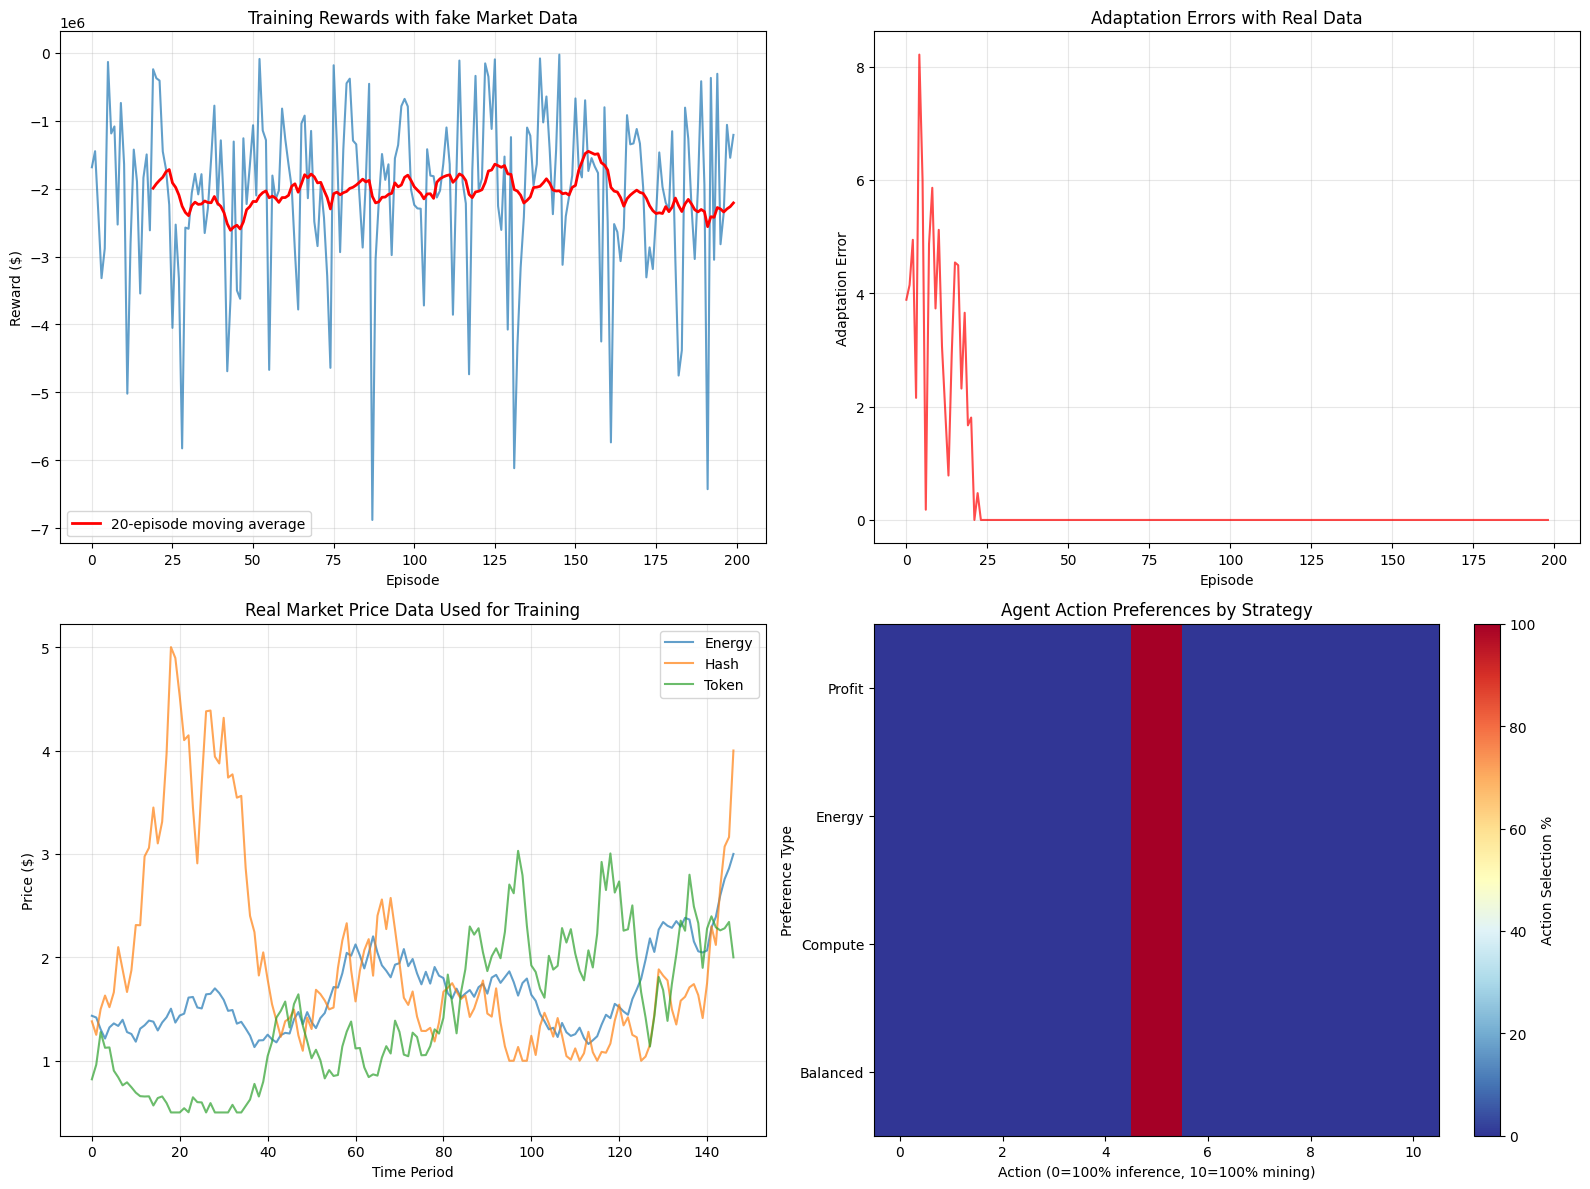

 Retraining completed with real market data!

 FINAL RESULTS WITH REAL DATA:
    Final average reward: $-2210098.74
    Final adaptation error: 0.000
    Total episodes: 200

 Agent behavior with real market data:
    Profit: Action 5 (50% inference, 50% mining)
    Energy: Action 5 (50% inference, 50% mining)
    Compute: Action 5 (50% inference, 50% mining)
    Balanced: Action 5 (50% inference, 50% mining)

 SYSTEM EXECUTION COMPLETED SUCCESSFULLY!
 Total episodes trained: 200
 Final average reward: -2107746.02
 Final adaptation error: 0.000


In [24]:

# Add this to main function call
# ========================
# SECTION 12: MAIN EXECUTION WITH ADAPTATION ERROR
# ========================

def retrain_with_real_data():
    """ Retrain the model with fake market data"""

    print(" RETRAINING WITH fake MARKET DATA")
    print("=" * 60)

    # Analyze real market data first
    energy_prices = [d["energy_price"] for d in REAL_MARKET_DATA]
    hash_prices = [d["hash_price"] for d in REAL_MARKET_DATA]
    token_prices = [d["token_price"] for d in REAL_MARKET_DATA]

    print(f" fake Market Analysis ({len(REAL_MARKET_DATA)} data points):")
    print(f"   Energy: ${min(energy_prices):.2f} - ${max(energy_prices):.2f} (avg: ${np.mean(energy_prices):.2f})")
    print(f"   Hash:   ${min(hash_prices):.2f} - ${max(hash_prices):.2f} (avg: ${np.mean(hash_prices):.2f})")
    print(f"   Token:  ${min(token_prices):.2f} - ${max(token_prices):.2f} (avg: ${np.mean(token_prices):.2f})")

    # Quick profitability analysis
    avg_energy = np.mean(energy_prices)
    avg_hash = np.mean(hash_prices)
    avg_token = np.mean(token_prices)

    # Mining profitability (1000 hash/watt efficiency)
    mining_revenue_per_watt = avg_hash * 1.0  # 1000 hash per 1000W = 1 hash per W
    mining_cost_per_watt = avg_energy * 0.001  # 1W = 0.001 kW
    mining_profit_per_watt = mining_revenue_per_watt - mining_cost_per_watt

    # Inference profitability (3330 tokens/watt efficiency)
    inference_revenue_per_watt = avg_token * 3.33  # 50000 tokens per 15000W = 3.33 tokens per W
    inference_cost_per_watt = avg_energy * 0.001
    inference_profit_per_watt = inference_revenue_per_watt - inference_cost_per_watt

    print(f"\n Expected Profitability Analysis:")
    print(f"   Mining profit per watt:    ${mining_profit_per_watt:.4f}")
    print(f"   Inference profit per watt: ${inference_profit_per_watt:.4f}")

    if inference_profit_per_watt > mining_profit_per_watt:
        print(f"    INFERENCE is {((inference_profit_per_watt/mining_profit_per_watt-1)*100):.1f}% more profitable!")
        expected_strategy = "Inference-focused allocations"
    else:
        print(f"    MINING is {((mining_profit_per_watt/inference_profit_per_watt-1)*100):.1f}% more profitable!")
        expected_strategy = "Mining-focused allocations"

    print(f"    Expected optimal strategy: {expected_strategy}")

    # Run training with real data
    print(f"\n Starting retraining with real market data...")
    print(f"   Episodes: 200 (increased for better learning)")
    print(f"   Using {len(REAL_MARKET_DATA)} real price data points")

    rewards, trained_agent, env, adaptation_errors = Learning_Loop_with_Adaptation(
        ep_num=200,  # More episodes for better learning with real data
        site_num=5,
        sample_coef=1.0
    )

    return rewards, trained_agent, env, adaptation_errors

def compare_training_results():
    """ Compare old vs new training results"""

    print("\n COMPARING TRAINING RESULTS")
    print("=" * 50)

    # Test agent with different preferences
    env = Environment()
    agent = Agent()

    test_preferences = [
        (np.array([0.8, 0.1, 0.1]), "Profit-focused"),
        (np.array([0.3, 0.6, 0.1]), "Energy-focused"),
        (np.array([0.3, 0.1, 0.6]), "Compute-focused"),
        (np.array([0.33, 0.33, 0.34]), "Balanced")
    ]

    print(" Testing agent decisions with real market data...")

    for pref_vector, pref_name in test_preferences:
        print(f"\n {pref_name}: {pref_vector}")

        # Test across different market conditions
        total_rewards = []
        action_counts = {i: 0 for i in range(len(ACTION_SPACE_RATIOS))}

        for i in range(10):  # Test 10 different market conditions
            env.time_step = i * 12  # Different time periods
            state = env.get_current_state()

            with torch.no_grad():
                q_values = agent.QNet(state, pref_vector)
                best_action = q_values.argmax().item()

            action_counts[best_action] += 1

            # Calculate reward for this action
            _, reward = env.step(best_action, pref_vector)
            total_rewards.append(reward)

        avg_reward = np.mean(total_rewards)
        most_common_action = max(action_counts.items(), key=lambda x: x[1])

        infer_ratio, mining_ratio = ACTION_SPACE_RATIOS[most_common_action[0]]

        print(f"   Average reward: ${avg_reward:.2f}")
        print(f"   Most common action: {most_common_action[0]} ({infer_ratio:.0%} inference, {mining_ratio:.0%} mining)")
        print(f"   Action diversity: {len([c for c in action_counts.values() if c > 0])}/11 different actions used")

def main_with_real_data():
    """ Main function using real market data"""

    print(" MOMI MARA - Multi-Objective Trading System")
    print(" RETRAINING WITH REAL MARKET DATA")
    print("=" * 70)

    # Quick analysis of real data
    print("\n📊 Real Market Data Analysis:")
    energy_range = f"${min(d['energy_price'] for d in REAL_MARKET_DATA):.2f}-${max(d['energy_price'] for d in REAL_MARKET_DATA):.2f}"
    hash_range = f"${min(d['hash_price'] for d in REAL_MARKET_DATA):.2f}-${max(d['hash_price'] for d in REAL_MARKET_DATA):.2f}"
    token_range = f"${min(d['token_price'] for d in REAL_MARKET_DATA):.2f}-${max(d['token_price'] for d in REAL_MARKET_DATA):.2f}"

    print(f"    {len(REAL_MARKET_DATA)} real price data points")
    print(f"    Energy prices: {energy_range}")
    print(f"     Hash prices: {hash_range}")
    print(f"    Token prices: {token_range}")

    # Retrain with real data
    rewards, trained_agent, env, adaptation_errors = retrain_with_real_data()

    # Enhanced plotting with real data insights
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Plot training rewards
    ax1.plot(rewards, alpha=0.7)
    ax1.set_title('Training Rewards with fake Market Data')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward ($)')
    ax1.grid(True, alpha=0.3)

    # Add moving average
    if len(rewards) > 20:
        moving_avg = np.convolve(rewards, np.ones(20)/20, mode='valid')
        ax1.plot(range(19, len(rewards)), moving_avg, 'r-', linewidth=2, label='20-episode moving average')
        ax1.legend()

    # Plot adaptation errors
    if adaptation_errors:
        ax2.plot(adaptation_errors, color='red', alpha=0.7)
        ax2.set_title('Adaptation Errors with Real Data')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Adaptation Error')
        ax2.grid(True, alpha=0.3)

    # Plot real market data
    energy_data = [d["energy_price"] for d in REAL_MARKET_DATA]
    hash_data = [d["hash_price"] for d in REAL_MARKET_DATA]
    token_data = [d["token_price"] for d in REAL_MARKET_DATA]

    ax3.plot(energy_data, label='Energy', alpha=0.7)
    ax3.plot(hash_data, label='Hash', alpha=0.7)
    ax3.plot(token_data, label='Token', alpha=0.7)
    ax3.set_title('Real Market Price Data Used for Training')
    ax3.set_xlabel('Time Period')
    ax3.set_ylabel('Price ($)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Test final agent performance
    test_preferences = [
        np.array([0.8, 0.1, 0.1]),   # Profit-focused
        np.array([0.3, 0.6, 0.1]),   # Energy-focused
        np.array([0.3, 0.1, 0.6]),   # Compute-focused
        np.array([0.33, 0.33, 0.34]) # Balanced
    ]

    action_distributions = []
    pref_names = ["Profit", "Energy", "Compute", "Balanced"]

    for i, test_pref in enumerate(test_preferences):
        action_counts = {j: 0 for j in range(len(ACTION_SPACE_RATIOS))}

        # Test across multiple market conditions
        for market_step in range(20):
            env.time_step = market_step * 6  # Different market conditions
            test_state = env.get_current_state()

            with torch.no_grad():
                q_values = trained_agent.QNet(test_state, test_pref)
                best_action = q_values.argmax().item()

            action_counts[best_action] += 1

        # Convert to percentages
        total_actions = sum(action_counts.values())
        action_percentages = [count/total_actions*100 for count in action_counts.values()]
        action_distributions.append(action_percentages)

    # Plot action distribution heatmap
    import matplotlib.patches as patches
    action_matrix = np.array(action_distributions)
    im = ax4.imshow(action_matrix, cmap='RdYlBu_r', aspect='auto')

    ax4.set_title('Agent Action Preferences by Strategy')
    ax4.set_xlabel('Action (0=100% inference, 10=100% mining)')
    ax4.set_ylabel('Preference Type')
    ax4.set_yticks(range(len(pref_names)))
    ax4.set_yticklabels(pref_names)
    ax4.set_xticks(range(0, 11, 2))

    # Add colorbar
    plt.colorbar(im, ax=ax4, label='Action Selection %')

    plt.tight_layout()
    plt.show()

    print(" Retraining completed with real market data!")

    # Final analysis
    final_reward = np.mean(rewards[-20:]) if len(rewards) >= 20 else np.mean(rewards)
    final_adaptation = np.mean(adaptation_errors[-20:]) if adaptation_errors and len(adaptation_errors) >= 20 else 0

    print(f"\n FINAL RESULTS WITH REAL DATA:")
    print(f"    Final average reward: ${final_reward:.2f}")
    print(f"    Final adaptation error: {final_adaptation:.3f}")
    print(f"    Total episodes: {len(rewards)}")

    # Test agent with different preferences
    print(f"\n Agent behavior with real market data:")

    for i, (test_pref, pref_name) in enumerate(zip(test_preferences, pref_names)):
        env.time_step = 50  # Use middle market conditions
        test_state = env.get_current_state()

        with torch.no_grad():
            q_values = trained_agent.QNet(test_state, test_pref)
            best_action = q_values.argmax().item()

        infer_ratio, mining_ratio = ACTION_SPACE_RATIOS[best_action]

        print(f"    {pref_name}: Action {best_action} ({infer_ratio:.0%} inference, {mining_ratio:.0%} mining)")

    return trained_agent, env, rewards, adaptation_errors

if __name__ == "__main__":
    print(" STARTING MOMI MARA MULTI-OBJECTIVE TRADING SYSTEM")
    print(" With Research-Based Adaptation Error Analysis")
    print("=" * 70)

    try:
        trained_agent, environment, reward_history, adaptation_error_history = main_with_real_data()

        print("\n SYSTEM EXECUTION COMPLETED SUCCESSFULLY!")
        print(f" Total episodes trained: {len(reward_history)}")
        print(f" Final average reward: {np.mean(reward_history[-10:]):.2f}")
        if adaptation_error_history:
            print(f" Final adaptation error: {np.mean(adaptation_error_history[-10:]):.3f}")

    except Exception as e:
        print(f"\n Error during execution: {e}")
        print(" Please check all dependencies are installed:")
        print("   pip install torch numpy matplotlib pandas requests")
        import traceback
        traceback.print_exc()

